# Uporaba razdalj in podobnosti

V tem zvezku predstavimo, kako med prej dobljenimi vložitvami dokumentov računamo in uporabljamo razdalje in podobnosti.

Za začetek si spet preko API-ja pridobimo besedila zadnjih 100 predlogov vladi, ki vsebujejo vsaj 50 znakov ter iz datotek preberemo fastText in tf-idf vektorje iz prejšnjega primera.

In [22]:
from textsemantics.server_api import ServerAPI
import numpy as np
from scipy.sparse import load_npz

api = ServerAPI()
metadata = api.get_metadata('predlogi-vladi', sample_size=100, sampling_strategy='latest')

metadata['text'] = api.get_texts(urls=metadata['text'])
metadata = metadata[metadata["text"].apply(lambda x: len(x) > 50)]
titles = metadata['title'].values
texts = metadata['text'].values

ft = np.load('data/ft.npy')
tfidf = load_npz('data/tfidf.npz').toarray()
word_embs = np.load('data/words.npy')

## Računanje razdalj med dokumenti

Razdaljo med dvema dokumentoma izračunamo kot razdaljo med njihovima vektorskima predstavitvama. Ker imamo mehanizem za računanje razdalj, lahko za želeni dokument poiščemo k dokumentov, ki so mu najbližji v vektorskem prostoru. Poiščimo 3 najbližje sosede enega dokumenta v našem seznamu.

In [23]:
def cos_sim(x, y):
    return np.dot(x, y) / (np.linalg.norm(x) * np.linalg.norm(y))

def knn(embs, ind=0, k=3):
    dists = [1 - cos_sim(embs[i], embs[ind]) if i != ind else 1
             for i in range(embs.shape[0])]
    inds = np.argsort(dists)
    return inds[:min(k, embs.shape[0])]

In [24]:
ft_nn = knn(ft, ind=20, k=3)
tfidf_nn = knn(tfidf, ind=20, k=3)

print(f'ID treh najbližjih sosedov za fastText {list(ft_nn)}')
print(f'ID treh najbližjih sosedov za vrečo besed {list(tfidf_nn)}')

ID treh najbližjih sosedov za fastText [7, 18, 30]
ID treh najbližjih sosedov za vrečo besed [30, 18, 7]


Izkaže se, da z uporabo obeh vložitev odkrijemo iste 3 najbližje sosede. Poglejmo besedila prvega dokumenta in njegovih najbližjih sosedov.


In [25]:
from IPython.display import Markdown, display
display(Markdown(
    f"## {titles[20]}\n{texts[20]}\n\n ## {titles[ft_nn[0]]}\n{texts[ft_nn[0]]}\n\n" +
    f"## {titles[ft_nn[1]]}\n{texts[ft_nn[1]]}\n\n ## {titles[ft_nn[2]]}\n{texts[ft_nn[2]]}\n\n"))


## Ponovno odprtje srednjih šol
Nekateri srednješolci imamo počasi že dovolj šole na daljavo, ker nam nič ne koristi. Še posebej zdaj ne, ker nas čaka matura in mislim, da je čas za ponovno odprtje srednjih šol. Če ne za vse pa samo za tiste, ki imamo maturo in zaključni izpit.

 ## Podaljšanje šolanja na daljavo od 5. razreda naprej
Predlagam, da se šola na daljavo podaljša do konca prvega poletja v onovnih in srednjih šolah oz. prvega semestra na fakultetah. Šolo na daljavo predlagam od 5. razreda osnovne šole naprej, razen za učence s posebnimi potrebami in učno pomočjo. Najbolj se covid-19 da zajeziti s študiranjem na daljavo na fakultetah saj tam si gibljejo študenje iz različnih krajev, nenormalna gužva je na javnih prevozih in so tudi najbolj samostojni pri učenju na daljavo.

## Srednje šole podaljšanja počitnic ne želijo
Podaljšanja počitnic si medtem ne želijo na srednjih šolah, je sporočila predsednica Društva ravnateljev srednjih šol Nives Počkar, ki poudarja, da so na pouk na daljavo dobro pripravljeni, nadomeščanje pa bi bilo prenaporno.
To je odločitev Društva ravnateljev srednjih šol. V kolikor bi upoštevali poglede dijakov, bi bila odločitev drugačna. Njim so šole prvenstveno namenjene. Se je kdo vprašal ali ni šolanje na daljavo za dijake prenaporno ?
Tako Nemčija in Francija zagovarjata stališče, da bodo šole zapirali, ko res ne bo več nobenih drugih možnosti.
Prav tako so naredili analizo posledic zapiranja šol v prvem valu korona krize. Rezultati so zelo zaskrbljujoči. V Sloveniji pa seveda te analize ni. Posledično so tudi ukrepi temu primerni.
 

 ## Ukinitev mature
Glede na stanje okoli virusa, predlagam, da bi zaključni izpit oziroma maturo začasno ali trajno ukinili. Že lanski zaključni letniki so na maturi imeli kar precej težav, mislim, da to leto ne bo nič drugače - še slabše, razlog tega pa je, da se pri pouku na daljavo zelo težko kaj naučiš, učitelji nimajo kontrole nad dijakom, nekatere predmete je težje razlagat preko videoklica kot pa v živo, itd.
To je moj predlog, vem, da se marsikdo ne bo strinjal s tem, vendar pa do leta 1994/1995 ni bilo mature v Sloveniji. Takrat so so začeli uveljavljati (popravite me če se motim).



Vsi štirje predlogi se nanašajo na šolanje na daljavo. Na takšen enostaven način lahko za poljuben predlog vladi poiščemo obstoječe predloge, ki so mu podobni.

Razdalje lahko dodatno poudarimo s hierarhičnim razvrščanjem. Izberimo si zgornje 4 preloge vladi in prve 4 predloge na seznamu ter narišimo dendrogram. 

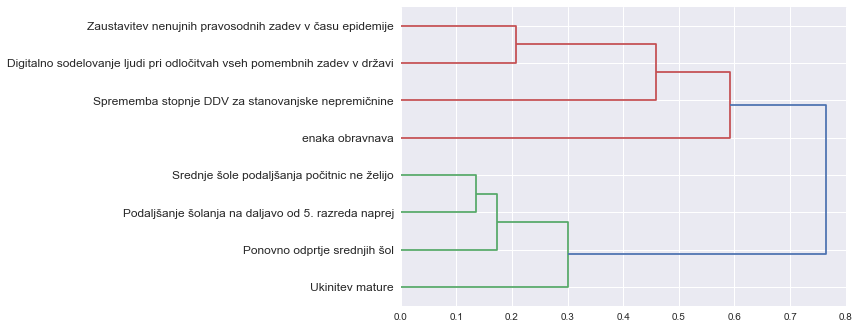

In [30]:
from scipy.cluster.hierarchy import ward, dendrogram
from sklearn.metrics.pairwise import cosine_similarity
from matplotlib import pyplot as plt

plt.style.use('seaborn')

np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
idx = list(ft_nn) + [20, 1, 2, 3, 4]
dist_mat = 1 - cosine_similarity(ft[idx, :])
linkage = ward(dist_mat)
_ = dendrogram(linkage, color_threshold=0.7, orientation='right', 
               labels=[titles[i] for i in idx])

Vidimo, da predlogi, ki govorijo o šolanju tvorijo eno skupino in da so med sabo bolj podobni kot dokumenti, ki tvorijo drugo skupino.

## Podobnost med dokumentom in besedo

Predpostavimo, da imamo seznam besed, za katere želimo vedeti, ali dobro opisujejo določeni dokument. To lahko izvemo na način podoben zgoraj opisanemu. Ker smo z modelom fastText dobili vložitve besed, nato pa le te združili v vložitve dokumentov, so tako besede kot dokumenti vektorji v istem vektorskem prostoru. Zato lahko računamo razdalje (podobnosti) med besedami in dokumenti. Vemo, da se zgornji predlog vladi nanaša na šolanje na daljavo. Izračunajmo kosinusno podobnost (definirana je kot 1 - razdalja) med tem predlogom in besedami šola, počitnice, semafor in tehnologija.

In [28]:
word_embs = np.load('data/words.npy')
for i, word in enumerate(['šola', 'počitnice', 'semafor', 'tehnologija']):
    print(f"Podobnost med dokumentom in besedo {word}: " + 
          f"{cos_sim(ft[0], word_embs[i, :]):.2f}")

Podobnost med dokumentom in besedo šola: 0.36
Podobnost med dokumentom in besedo počitnice: 0.41
Podobnost med dokumentom in besedo semafor: 0.31
Podobnost med dokumentom in besedo tehnologija: 0.35


Kot vidimo, sta besedi šola in počitnice bolj podobni dokumentu kot besedi semafor in tehnologija.